Ustawienie ścieżki do zdjęć

In [1]:
# path = 'datasets/'
path = ''

Importowanie niezbednych bibliotek

In [2]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

Wyświetlam przykładowe zdjęcia płuc jedne są zdrowe, drugie mają wirusowe zapalenie płuc

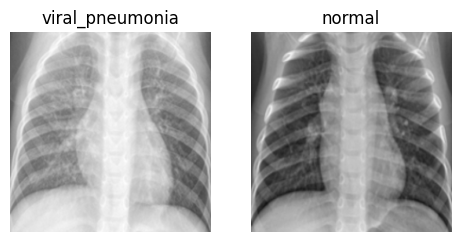

In [12]:
dataset_path = path+"lung_diseases/train"
plt.figure(1, figsize=(15, 9))
n = 0
for category in os.listdir(dataset_path):
  n += 1
  random_file = random.choice(os.listdir(os.path.join(dataset_path, category)))
  random_img = cv2.imread(os.path.join(dataset_path, category, random_file))
  random_img = cv2.cvtColor(random_img, cv2.COLOR_BGR2RGB)
  plt.subplot(2, 5, n)
  plt.axis('off')
  plt.imshow(random_img)
  plt.title(category)

Ustawiam parametry takie jak rozmiar obrazka, liczbę kategorii, liczbę epok i inne

In [50]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 50
FEATURE_EXTRACTION_EPOCHS = 10
FINE_TUNING_EPOCHS = 10
CATEGORIES = 2
FEATURE_EXTRACTION_LR = 1e-3
FINE_TUNING_LR = 1e-5

Definiujemy generatory danych z podanych folderów.

In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(path+"./lung_diseases/train/",
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(path+"./lung_diseases/test/",
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 200 images belonging to 2 classes.
Testing images:
Found 500 images belonging to 2 classes.


Będę używać sieci EfficientNet do której dodam dodatkową wartwę neuronów.
Poniżej link do artykułu opisującego tę sięć.

<a href="https://arxiv.org/abs/1905.11946">https://arxiv.org/abs/1905.11946</a>

In [15]:
tf.keras.backend.clear_session()

Na początku chcę jedynie trenować dodaną przez siebie wartwę a nie zmieniać wag sieci EfficienNet.

In [16]:
trainable = False

In [41]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_feature_extractor_layer = hub.KerasLayer(efficientnet_url,
                                        trainable=trainable,
                                        name='efficientnet_feature_extractor_layer',
                                        input_shape=IMAGE_SHAPE+(3,)
                                      )
model = tf.keras.Sequential([
  resnet_feature_extractor_layer,
  tf.keras.layers.Dense(CATEGORIES, activation='softmax', name='output_layer')
])

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_feature_extrac  (None, 1280)             4049564   
 tor_layer (KerasLayer)                                          
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [43]:
model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=FEATURE_EXTRACTION_LR),
                     metrics=['accuracy'])

In [44]:
model_history = model.fit(train_data,
                          epochs=FEATURE_EXTRACTION_EPOCHS,
                          validation_data=test_data
                                )

Epoch 1/10
4/4 [==============================] - 70s 18s/step - loss: 0.6779 - accuracy: 0.5950 - val_loss: 0.6736 - val_accuracy: 0.5560
Epoch 2/10
4/4 [==============================] - 55s 17s/step - loss: 0.5890 - accuracy: 0.6650 - val_loss: 0.6507 - val_accuracy: 0.5980
Epoch 3/10
4/4 [==============================] - 56s 18s/step - loss: 0.5164 - accuracy: 0.8100 - val_loss: 0.6969 - val_accuracy: 0.5740
Epoch 4/10
4/4 [==============================] - 57s 18s/step - loss: 0.4603 - accuracy: 0.8200 - val_loss: 0.6176 - val_accuracy: 0.6340
Epoch 5/10
4/4 [==============================] - 57s 18s/step - loss: 0.4132 - accuracy: 0.8300 - val_loss: 0.5987 - val_accuracy: 0.6500
Epoch 6/10
4/4 [==============================] - 56s 18s/step - loss: 0.3853 - accuracy: 0.8300 - val_loss: 0.5919 - val_accuracy: 0.6560
Epoch 7/10
4/4 [==============================] - 56s 18s/step - loss: 0.3584 - accuracy: 0.8400 - val_loss: 0.5946 - val_accuracy: 0.6360
Epoch 8/10
4/4 [===========

In [45]:
model.trainable = True

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_feature_extrac  (None, 1280)             4049564   
 tor_layer (KerasLayer)                                          
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [48]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=float(FINE_TUNING_LR)),
              metrics=["accuracy"])

In [51]:
model_history = model.fit(train_data,
                          epochs=FEATURE_EXTRACTION_EPOCHS+FINE_TUNING_EPOCHS,
                          initial_epoch=FEATURE_EXTRACTION_EPOCHS,
                          validation_data=test_data,
                          )

Epoch 11/20
4/4 [==============================] - 107s 29s/step - loss: 0.1518 - accuracy: 1.0000 - val_loss: 0.8505 - val_accuracy: 0.6480
Epoch 12/20
4/4 [==============================] - 103s 29s/step - loss: 0.1484 - accuracy: 1.0000 - val_loss: 0.8616 - val_accuracy: 0.6500
Epoch 13/20
4/4 [==============================] - 103s 29s/step - loss: 0.1450 - accuracy: 1.0000 - val_loss: 0.8866 - val_accuracy: 0.6480
Epoch 14/20
4/4 [==============================] - 105s 30s/step - loss: 0.1420 - accuracy: 1.0000 - val_loss: 0.9132 - val_accuracy: 0.6440
Epoch 15/20
4/4 [==============================] - 101s 28s/step - loss: 0.1432 - accuracy: 1.0000 - val_loss: 0.9414 - val_accuracy: 0.6420
Epoch 16/20
4/4 [==============================] - 103s 29s/step - loss: 0.1439 - accuracy: 1.0000 - val_loss: 0.9762 - val_accuracy: 0.6420
Epoch 17/20
4/4 [==============================] - 102s 29s/step - loss: 0.1415 - accuracy: 1.0000 - val_loss: 1.0185 - val_accuracy: 0.6360
Epoch 18/20
4